## Importing Libraries

In [ ]:
!pip install tensorflow-addons 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.7 MB/s 


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator 
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Model

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb

## Extracting Files

In [ ]:
c = r"covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/image"
l = r"covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images"
n = r"covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
p = r"covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/image"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/inputt/covid19-radiography-database.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/image/Viral Pneumonia-3422.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/image/Viral Pneumonia-3423.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/image/Viral Pneumonia-3424.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/image/Viral Pneumonia-3425.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/image/Viral Pneumonia-3426.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/image/Viral Pneumonia-3427.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/image/Viral Pneumonia-3428.png  
  inflating: covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/image/Viral Pneumonia-3429

In [ ]:
!unzip drive/MyDrive/models/dense201.zip

Archive:  drive/MyDrive/models/dense201.zip
  inflating: Covid-dense201.h5       


In [ ]:
!unzip drive/MyDrive/models/vgg19.zip

Archive:  drive/MyDrive/models/vgg19.zip
  inflating: Covid-vgg19.h5          


In [ ]:
!unzip drive/MyDrive/train_test/train_valid_test.zip

Archive:  drive/MyDrive/train_test/train_valid_test.zip
  inflating: test_data.csv           
  inflating: train_data.csv          
  inflating: valid_data.csv          


In [ ]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(l), 5000) + random.sample(os.listdir(n), 5000) + os.listdir(p)

### Classes
* 0 -> Normal
* 1 -> Lung Opacity
* 2 -> Viral Pneumonia
* 3 -> COVID

In [ ]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(3))
    elif category == 'Viral Pneumonia':
        categories.append(str(2))
    elif category == 'Lung_Opacity':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [ ]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    elif 'Lung_Opacity' in filenames[i]:
        filenames[i] = os.path.join(l, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,covid19-radiography-database/COVID-19_Radiogra...,3
1,covid19-radiography-database/COVID-19_Radiogra...,3
2,covid19-radiography-database/COVID-19_Radiogra...,3
3,covid19-radiography-database/COVID-19_Radiogra...,3
4,covid19-radiography-database/COVID-19_Radiogra...,3


## Data Visualization

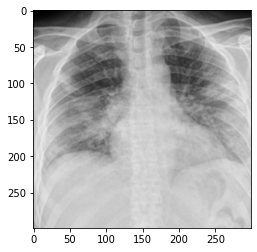

In [ ]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Splitting Train, Validation & Test Data

In [ ]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [ ]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Reading Train,Test and Validation Data From File

In [ ]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
valid_data = pd.read_csv('valid_data.csv')

In [ ]:
train_data = train_data.drop(["Unnamed: 0"],axis = 1)
valid_data = valid_data.drop(["Unnamed: 0"],axis = 1)
test_data = test_data.drop(["Unnamed: 0"],axis = 1)

In [ ]:
train_data["filename"] = train_data["filename"].astype("object")
train_data["category"] = train_data["category"].astype("string")
valid_data["filename"] = valid_data["filename"].astype("object")
valid_data["category"] = valid_data["category"].astype("string")
test_data["filename"] = test_data["filename"].astype("object")
test_data["category"] = test_data["category"].astype("string")

## Saving Train, Test and Validation Data as .csv File

In [ ]:
train_data.to_csv(r'train_data.csv')

In [ ]:
test_data.to_csv(r'test_data.csv')

In [ ]:
valid_data.to_csv(r'valid_data.csv')

## Data Augmentation

In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16
)

Found 16000 validated image filenames belonging to 4 classes.


In [ ]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16
)

Found 2000 validated image filenames belonging to 4 classes.


In [ ]:
test_data_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16
)

Found 2000 validated image filenames belonging to 4 classes.


## Model Training - VGG19

#### Model Architecture

In [ ]:
baseModel = VGG19(input_shape=(224,224,3), weights="imagenet", include_top=False,classes=4,classifier_activation="softmax")

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = Flatten()(headModel)
headModel = Dense(4096, activation="relu")(headModel)
headModel = Dense(4096, activation="relu")(headModel)
headModel = Dense(4, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

80150528/80134624 [==============================] - 1s 0us/step


#### Model Summary

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Optimizer - Adam

In [ ]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=['accuracy',
                        "Precision",
                        "Recall",
                        tfa.metrics.CohenKappa(num_classes=4),
                        tfa.metrics.F1Score(num_classes=4, threshold=0.5)])

In [ ]:
epochs = 10
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
1000/1000 [==============================] - 263s 247ms/step - loss: 0.9284 - accuracy: 0.7236 - precision: 0.7681 - recall: 0.6638 - cohen_kappa: 0.6315 - f1_score: 0.7080 - val_loss: 0.4914 - val_accuracy: 0.8150 - val_precision: 0.8557 - val_recall: 0.7680 - val_cohen_kappa: 0.7533 - val_f1_score: 0.8045
Epoch 2/10
1000/1000 [==============================] - 226s 226ms/step - loss: 0.5317 - accuracy: 0.7933 - precision: 0.8242 - recall: 0.7559 - cohen_kappa: 0.7244 - f1_score: 0.7866 - val_loss: 0.4082 - val_accuracy: 0.8585 - val_precision: 0.8858 - val_recall: 0.8105 - val_cohen_kappa: 0.8113 - val_f1_score: 0.8451
Epoch 3/10
1000/1000 [==============================] - 226s 226ms/step - loss: 0.4756 - accuracy: 0.8163 - precision: 0.8430 - recall: 0.7886 - cohen_kappa: 0.7551 - f1_score: 0.8135 - val_loss: 0.4049 - val_accuracy: 0.8515 - val_precision: 0.8682 - val_recall: 0.8270 - val_cohen_kappa: 0.8020 - val_f1_score: 0.8487
Epoch 4/10
1000/1000 [==================

## Loading Model

In [ ]:
model = keras.models.load_model(r"Covid-vgg19.h5")

## Evaluating Model

In [ ]:
results = model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
print("test loss:", results[0])
print("test accuracy", results[1])
print("test precision", results[2])
print("test recall", results[3])
print("test cohen kappa", results[4])

test loss: 0.3171985447406769
test accuracy 0.8725000023841858
test precision 0.8862583637237549
test recall 0.8610000014305115
test cohen kappa 0.8299999833106995


## Model Testing

True value is : COVID
Prediction is:
COVID


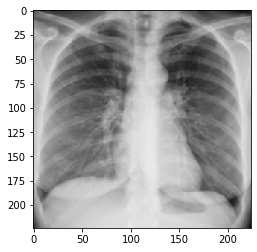

In [ ]:
sample = random.choice(test_data['filename'])
category = sample.split('/')[2]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'
elif category == 'Lung_Opacity':
    true = 'Lung Opacity'
else:
    true = 'Normal'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img / 255.0
img = np.expand_dims(img, axis=0)
img = np.vstack([img])
img = img.reshape((1, 224, 224, 3))
#img = tf.keras.applications.vgg19.preprocess_input(img)

result = model.predict(img,batch_size=15)

result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Lung Opacity")
elif result == 2:
    print("Viral Pneumonia")
else:
    print("COVID")
    
plt.imshow(image)

## Saving Model

In [ ]:
model.save('Covid-vgg19.h5')

## Getting Last Layer of Model

In [ ]:
extract = Model(model.inputs, model.get_layer("dense_1").output)

In [ ]:
feature_train_dataset = []
for data in train_data["filename"]:
  image = load_img(data, target_size=(224, 224))
  img = img_to_array(image)
  img = img / 255.0
  img = np.expand_dims(img, axis=0)
  img = np.vstack([img])
  img = img.reshape((1, 224, 224, 3))

  result = extract.predict(img)

  feature_vector = {
      "feature" : result,
      "label" : data.split("/")[4].split(".")[0]
  }

  feature_train_dataset.append(feature_vector)

In [ ]:
feature_test_dataset = []
for data in test_data["filename"]:
  image = load_img(data, target_size=(224, 224))
  img = img_to_array(image)
  img = img / 255.0
  img = np.expand_dims(img, axis=0)
  img = np.vstack([img])
  img = img.reshape((1, 224, 224, 3))

  result = extract.predict(img)

  feature_vector = {
      "feature" : result,
      "label" : data.split("/")[4].split(".")[0]
  }

  feature_test_dataset.append(feature_vector)

In [ ]:
feature_valid_dataset = []
for data in valid_data["filename"]:
  image = load_img(data, target_size=(224, 224))
  img = img_to_array(image)
  img = img / 255.0
  img = np.expand_dims(img, axis=0)
  img = np.vstack([img])
  img = img.reshape((1, 224, 224, 3))

  result = extract.predict(img)

  feature_vector = {
      "feature" : result,
      "label" : data.split("/")[4].split(".")[0]
  }

  feature_valid_dataset.append(feature_vector)

In [ ]:
ftraind = np.array(feature_train_dataset)
ftestd = np.array(feature_test_dataset)
fvalidd = np.array(feature_valid_dataset)

In [ ]:
np.save("vgg19_train_feature2.npy",ftraind)

In [ ]:
np.save("vgg19_test_feature2.npy",ftestd)

In [ ]:
np.save("vgg19_valid_feature.npy",fvalidd)

## DenseNet201

#### Model Architecture

In [ ]:
denseModel = tf.keras.applications.DenseNet201(input_shape=(224,224,3), weights='imagenet', include_top=False, classes=4, pooling="avg")

for layer in denseModel.layers:
    layer.trainable = False

headModel = denseModel.output
headModel = Dense(4, activation='softmax')(headModel)

modeldense = Model(inputs=denseModel.input, outputs=headModel)

74850304/74836368 [==============================] - 3s 0us/step


#### Model Summary

In [ ]:
modeldense.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

#### Optimizer - Adam

In [ ]:
opt = Adam(learning_rate=0.0001)
modeldense.compile(optimizer="adam", 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy',
                            "Precision",
                            "Recall",
                            tfa.metrics.CohenKappa(num_classes=4),
                            tfa.metrics.F1Score(num_classes=4, threshold=0.5)])

In [ ]:
epochs = 20
history2 = modeldense.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs)

Epoch 1/20
1000/1000 [==============================] - 268s 247ms/step - loss: 0.5489 - accuracy: 0.7833 - precision: 0.8362 - recall: 0.7216 - cohen_kappa: 0.7111 - f1_score: 0.7714 - val_loss: 0.4482 - val_accuracy: 0.8245 - val_precision: 0.8615 - val_recall: 0.7965 - val_cohen_kappa: 0.7660 - val_f1_score: 0.8230
Epoch 2/20
1000/1000 [==============================] - 250s 250ms/step - loss: 0.4225 - accuracy: 0.8384 - precision: 0.8641 - recall: 0.8098 - cohen_kappa: 0.7846 - f1_score: 0.8348 - val_loss: 0.4546 - val_accuracy: 0.8340 - val_precision: 0.8469 - val_recall: 0.8075 - val_cohen_kappa: 0.7787 - val_f1_score: 0.8278
Epoch 3/20
1000/1000 [==============================] - 245s 245ms/step - loss: 0.3924 - accuracy: 0.8466 - precision: 0.8674 - recall: 0.8229 - cohen_kappa: 0.7955 - f1_score: 0.8436 - val_loss: 0.4205 - val_accuracy: 0.8315 - val_precision: 0.8521 - val_recall: 0.8040 - val_cohen_kappa: 0.7753 - val_f1_score: 0.8171
Epoch 4/20
1000/1000 [==================

## Loading Model

In [ ]:
modeldense = keras.models.load_model(r"Covid-dense201.h5")

## Evaluating Model

In [ ]:
densenet201_results = modeldense.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
print("test loss:", densenet201_results[0])
print("test accuracy", densenet201_results[1])
print("test precision", densenet201_results[2])
print("test recall", densenet201_results[3])
print("test cohen kappa", densenet201_results[4])

test loss: 0.3474462926387787
test accuracy 0.8690000176429749
test precision 0.878413200378418
test recall 0.8525000214576721
test cohen kappa 0.8253333568572998


## Testing Model

True value is : Lung Opacity
Prediction is:
Lung Opacity


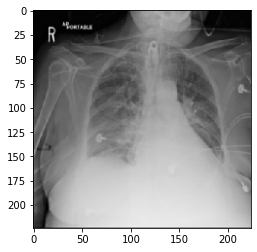

In [ ]:
sample = random.choice(test_data['filename'])
category = sample.split('/')[2]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'
elif category == 'Lung_Opacity':
    true = 'Lung Opacity'
else:
    true = 'Normal'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img / 255.0
img = np.expand_dims(img, axis=0)
img = np.vstack([img])
img = img.reshape((1, 224, 224, 3))
#img = tf.keras.applications.vgg19.preprocess_input(img)

result = modeldense.predict(img,batch_size=15)

result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Lung Opacity")
elif result == 2:
    print("Viral Pneumonia")
else:
    print("COVID")
    
plt.imshow(image)

## Saving Model

In [ ]:
modeldense.save('Covid-dense201.h5')

## Getting Last Layer of Model

In [ ]:
extract = Model(modeldense.inputs, modeldense.get_layer("avg_pool").output)

In [ ]:
feature_train_dataset2 = []
for data in train_data["filename"]:
    image = load_img(data, target_size=(224, 224))
    img = img_to_array(image)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    img = np.vstack([img])
    img = img.reshape((1, 224, 224, 3))
    result = extract.predict(img)

    feature_vector = {
      "feature" : result,
      "label" : data.split("/")[4].split(".")[0]
    }

    feature_train_dataset2.append(feature_vector)


KeyboardInterrupt: ignored

In [ ]:
feature_test_dataset2 = []
for data in test_data["filename"]:
  image = load_img(data, target_size=(224, 224))
  img = img_to_array(image)
  img = img / 255.0
  img = np.expand_dims(img, axis=0)
  img = np.vstack([img])
  img = img.reshape((1, 224, 224, 3))

  result = extract.predict(img)

  feature_vector = {
      "feature" : result,
      "label" : data.split("/")[4].split(".")[0]
  }

  feature_test_dataset2.append(feature_vector)

In [ ]:
feature_valid_dataset2 = []
for data in valid_data["filename"]:
  image = load_img(data, target_size=(224, 224))
  img = img_to_array(image)
  img = img / 255.0
  img = np.expand_dims(img, axis=0)
  img = np.vstack([img])
  img = img.reshape((1, 224, 224, 3))

  result = extract.predict(img)

  feature_vector = {
      "feature" : result,
      "label" : data.split("/")[4].split(".")[0]
  }

  feature_valid_dataset2.append(feature_vector)

In [ ]:
ftraind2 = np.array(feature_train_dataset2)
ftestd2 = np.array(feature_test_dataset2)
fvalidd2 = np.array(feature_valid_dataset2)

In [ ]:
np.save("densenet201_train_feature2.npy",ftraind2)

In [ ]:
np.save("densenet201_test_feature2.npy",ftestd2)

In [ ]:
np.save("densenet201_valid_feature.npy",fvalidd2)

In [ ]:
vgg19_train_features = ftraind
vgg19_test_features = ftestd
densenet201_train_feature = ftraind2
densenet201_test_feature = ftestd2

NameError: ignored

## Loading Feature Dataset

In [ ]:
!unzip drive/MyDrive/feature/feature_data.zip

Archive:  drive/MyDrive/feature/feature_data.zip
  inflating: vgg19_test_feature.npy  
  inflating: vgg19_train_feature.npy  
  inflating: densenet201_test_feature.npy  
  inflating: densenet201_train_feature.npy  


In [ ]:
vgg19_train_features = np.load("vgg19_train_feature.npy",allow_pickle=True)
vgg19_test_features = np.load("vgg19_test_feature.npy",allow_pickle=True)
densenet201_train_feature = np.load("densenet201_train_feature.npy",allow_pickle=True)
densenet201_test_feature = np.load("densenet201_test_feature.npy",allow_pickle=True)

In [ ]:
feature_dataset_train = []
feature_dataset_test = []
for i in range(16000):
  if(vgg19_train_features[i]["label"] == densenet201_train_feature[i]["label"]):
    fision = np.concatenate([vgg19_train_features[i]["feature"][0],densenet201_train_feature[i]["feature"][0]])
    feature_vector = {
      "feature" : fision,
      "label" : densenet201_train_feature[i]["label"]
    }
    feature_dataset_train.append(feature_vector)
for i in range(2000):
  if(vgg19_test_features[i]["label"] == densenet201_test_feature[i]["label"]):
    fision = np.concatenate([vgg19_test_features[i]["feature"][0],densenet201_test_feature[i]["feature"][0]])
    feature_vector = {
      "feature" : fision,
      "label" : densenet201_test_feature[i]["label"]
    }
    feature_dataset_test.append(feature_vector)

feature_dataset_train = np.array(feature_dataset_train)
feature_dataset_test = np.array(feature_dataset_test)

In [ ]:
feature_dataset_train

array([{'feature': array([0.        , 0.        , 0.        , ..., 0.17603526, 0.24900424,
              1.9536815 ], dtype=float32), 'label': 'COVID-4734'}                         ,
       {'feature': array([0.        , 0.        , 0.        , ..., 0.08252823, 0.18662344,
              0.40688917], dtype=float32), 'label': 'Normal-88'}                          ,
       {'feature': array([0.        , 0.        , 0.        , ..., 0.06158314, 1.0440136 ,
              1.3071016 ], dtype=float32), 'label': 'COVID-4436'}                         ,
       ...,
       {'feature': array([0.       , 0.       , 0.       , ..., 0.6365625, 0.2955148,
              1.1363115], dtype=float32), 'label': 'Normal-4657'}                    ,
       {'feature': array([0.        , 0.        , 0.        , ..., 0.2562463 , 0.00757957,
              0.55901015], dtype=float32), 'label': 'Normal-1150'}                        ,
       {'feature': array([0.        , 0.        , 0.        , ..., 0.19324458, 0.46

In [ ]:
a = []
b = []
a_test = []
b_test = []
for i in range(16000):
  a.append(feature_dataset_train[i]["feature"])
  b.append(feature_dataset_train[i]["label"].split("-")[0])
for i in range(2000):
  a_test.append(feature_dataset_test[i]["feature"])
  b_test.append(feature_dataset_test[i]["label"].split("-")[0])

In [ ]:
a = np.array(a)
b = np.array(b)
a_test = np.array(a_test)
b_test = np.array(b_test)

In [ ]:
a.shape

(16000, 6016)

## Classifying Images with Machine Learning Algorithms

In [ ]:
import pandas as pd
import sqlite3
import numpy as np
import math
import operator
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier

In [ ]:
X=np.array(a)
X_test = np.array(a_test)
    
scaler = preprocessing.MinMaxScaler((-1,1))

In [ ]:
model = MLPClassifier(max_iter=200, activation='relu',solver='adam',random_state=42)

In [ ]:
model = LogisticRegression(dual=False,multi_class='auto',solver='lbfgs',random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=100,criterion='entropy',verbose=3)

In [ ]:
model = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')

In [ ]:
model = KNeighborsClassifier(n_neighbors=10, weights='distance')

In [ ]:
model =  SVC(C=100,kernel='poly',gamma=0.005,verbose = 3)

In [ ]:
model = GaussianNB()

In [ ]:
model = xgb.XGBClassifier(verbosity=3)

In [ ]:
scaler.fit(X) 
scaler.fit(X_test)

model.fit(X, b)
y_pred = model.predict(a_test)

acc = metrics.accuracy_score(b_test, y_pred)*100
precision = metrics.precision_score(b_test, y_pred,average="micro")*100 
recall = metrics.recall_score(b_test, y_pred,average="micro")*100
f1_score = metrics.f1_score(b_test,y_pred,average="micro")*100

print("accuracy: ",acc)
print("precision: ",precision)
print("recall: ",recall)
print("f1 score: ",f1_score)

accuracy:  92.10000000000001
precision:  92.10000000000001
recall:  92.10000000000001
f1 score:  92.1


In [ ]:
index = random.randint(0, 2000)
sample = a_test[1]

In [ ]:
index

1422

In [ ]:
test_data.iloc[index]

filename    covid19-radiography-database/COVID-19_Radiogra...
category                                                    3
Name: 1422, dtype: object

In [ ]:
y_pred[index]

'COVID'

In [ ]:
if test_data.iloc[index]["category"] == "0":
  print("Normal")
elif test_data.iloc[index]["category"] == "1":
  print("Lung Opacity")
elif test_data.iloc[index]["category"] == "2":
  print("Viral Pneumonia")
else:
  print("COVID")

COVID


# Custom CNN

In [ ]:
from tensorflow.keras import datasets, layers, models

In [ ]:
cnn = models.Sequential([
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=1024, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=1024, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 512)     1180160   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 512)       2359808   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 512)      0

In [ ]:
cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                        "Precision",
                        "Recall",
                        tfa.metrics.CohenKappa(num_classes=4),
                        tfa.metrics.F1Score(num_classes=4, threshold=0.5)])

In [ ]:
cnn.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
1000/1000 [==============================] - 274s 260ms/step - loss: 1.0177 - accuracy: 0.5419 - precision: 0.7066 - recall: 0.3202 - cohen_kappa: 0.3892 - f1_score: 0.4031 - val_loss: 0.8507 - val_accuracy: 0.6610 - val_precision: 0.8851 - val_recall: 0.3505 - val_cohen_kappa: 0.5480 - val_f1_score: 0.4558
Epoch 2/20
1000/1000 [==============================] - 256s 256ms/step - loss: 0.7888 - accuracy: 0.6649 - precision: 0.7454 - recall: 0.5324 - cohen_kappa: 0.5532 - f1_score: 0.6038 - val_loss: 0.6762 - val_accuracy: 0.7120 - val_precision: 0.7697 - val_recall: 0.6335 - val_cohen_kappa: 0.6160 - val_f1_score: 0.6793
Epoch 3/20
1000/1000 [==============================] - 253s 253ms/step - loss: 0.6905 - accuracy: 0.7104 - precision: 0.7727 - recall: 0.6224 - cohen_kappa: 0.6139 - f1_score: 0.6804 - val_loss: 0.5867 - val_accuracy: 0.7595 - val_precision: 0.8327 - val_recall: 0.6570 - val_cohen_kappa: 0.6793 - val_f1_score: 0.7183
Epoch 4/20
1000/1000 [==================

KeyboardInterrupt: ignored

In [ ]:
cnn.evaluate_generator(test_generator)

[0.26561272144317627,
 0.9014999866485596,
 0.9078481197357178,
 0.8964999914169312,
 0.8686666488647461,
 array([0.8423115 , 0.8583162 , 0.9769308 , 0.93184125], dtype=float32)]

True value is : Lung Opacity
Prediction is:
Lung Opacity


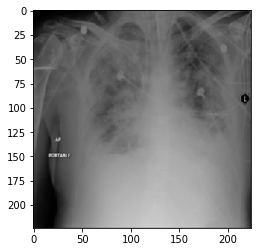

In [ ]:
sample = random.choice(test_data['filename'])
category = sample.split('/')[2]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'
elif category == 'Lung_Opacity':
    true = 'Lung Opacity'
else:
    true = 'Normal'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img / 255.0
img = np.expand_dims(img, axis=0)
img = np.vstack([img])
img = img.reshape((1, 224, 224, 3))
#img = tf.keras.applications.vgg19.preprocess_input(img)

result = cnn.predict(img,batch_size=15)

result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Lung Opacity")
elif result == 2:
    print("Viral Pneumonia")
else:
    print("COVID")
    
plt.imshow(image)